In [2]:
# imports
import os, sys
import numpy as np
import tensorflow as tf
import voxelmorph as vxm
import neurite as ne
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'
import h5py
import matplotlib.pyplot as plt

In [3]:
hf = h5py.File("../20201112_090735_SJR14.3_pan_w3_s1_IAA_30ms_1.8laser.h5", "r")

In [5]:
def remove_empty_key(keys):
    use_key = []
    for key in keys:
        if len(hf.get(key))!= 0:
            use_key.append(key)
    return use_key

In [45]:
keys = hf.keys()
use_key = remove_empty_key(keys)
x,y,z = hf.get('0')['frame'][0].shape
       
nb_entries = len(use_key) 
list_keys = list(use_key)

# Split train-validation set
# 80% train - 20% validation
ratio = 0.8
keys_random = np.random.permutation(nb_entries)
keys_train = keys_random[:int(nb_entries * ratio)]
keys_test  = keys_random[int(nb_entries * ratio):]

In [35]:
def to_MIP(data, list_keys, axis):
    """ Mean intensity projection (MIP) to axis 
        Arguments :
            data : h5 data
            list_keys : list of keys contained in data
            axis : axis for the projection
        Returns :
            MIP : np.array of dimensions (nb_vol, x, y, 3) of 
                  the MIP.
                  The last dimension contains the RGB values
            MIP_avg : np.array of dimensions (nb_vol, x, y) of 
                      the MIP.
                      The last dimension contains the mean RGB values
    """
    nb_vol = len(list_keys)
    x,y,z = data.get('0')['frame'][0].shape

    #
    MIP = np.empty((nb_vol, x, y, 3))
    MIP_avg = np.empty((nb_vol, x, y))
    MIP_3 = np.zeros((x, y))

    for i,key in enumerate(list_keys):
        MIP_1 = np.max(data.get(key)["frame"][0], axis = axis)
        MIP_2 = np.max(data.get(key)["frame"][1], axis = axis)
        MIP[i, ...] = np.dstack((MIP_1/255, MIP_2/255, MIP_3/255))
        MIP_avg[i, ...] = (MIP_1/255 + MIP_2/255 + MIP_3/255)/3
            
    return MIP, MIP_avg

In [36]:
MIP, MIP_avg = to_MIP(hf, list_keys, axis = 2)

In [37]:
print(MIP.shape, MIP_avg.shape)

(572, 512, 512, 3) (572, 512, 512)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

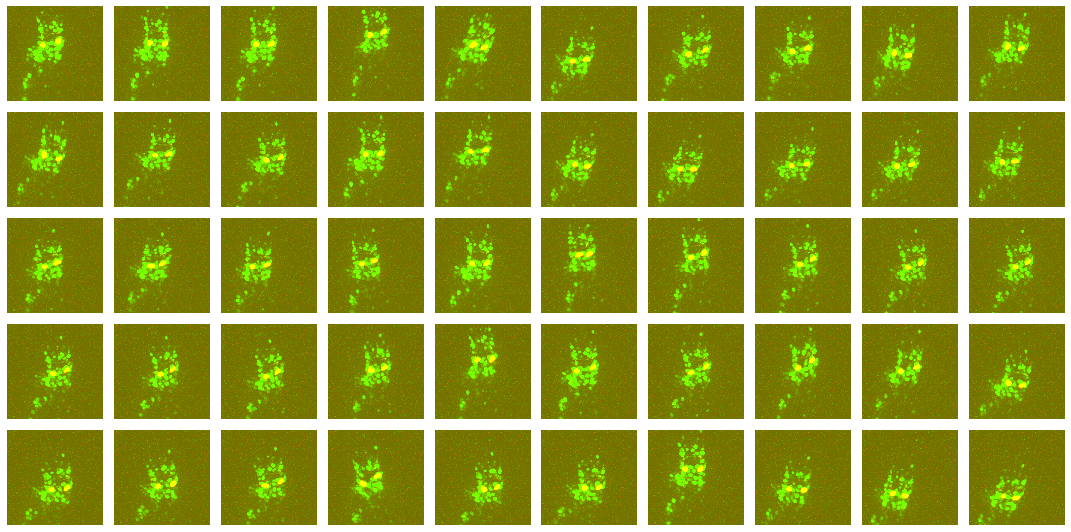

In [38]:
# Plot true RGB MIP images
plots = [MIP[i] for i in range(50)]
ne.plot.slices(plots, do_colorbars=True, grid = [5,10]);

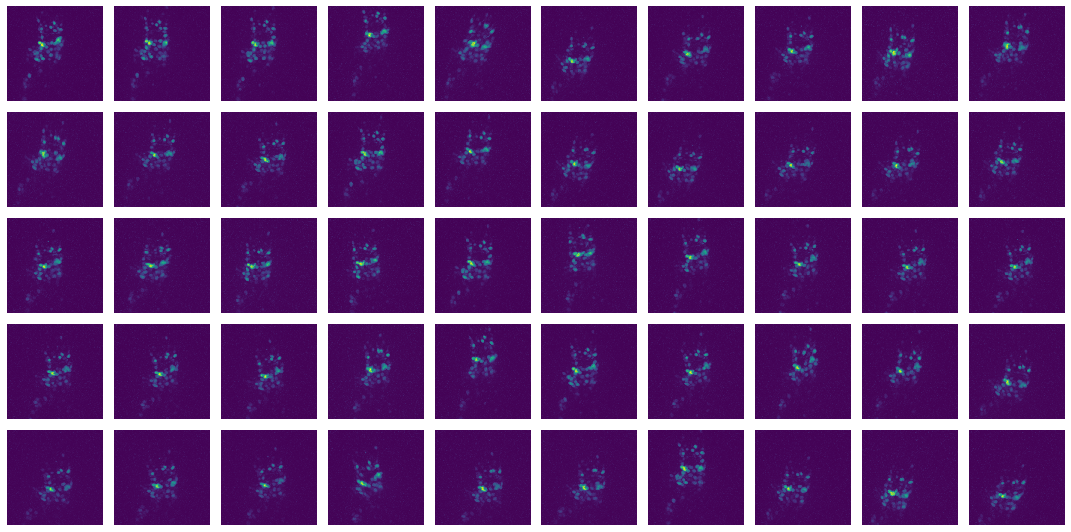

In [39]:
# Plot true RGB MIP images
plots = [MIP_avg[i] for i in range(50)]
ne.plot.slices(plots, do_colorbars=True, grid = [5,10]);

In [40]:
def vxm_data_generator(x_data, batch_size=32):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

In [41]:
# Load training set
slices_train = np.zeros((len(keys_train),512,512))
for i, key in enumerate(keys_train):
    slices_train[i] = MIP_avg[int(key)]

# Load the validation set 
slices_test = np.zeros((len(keys_test),512,512))
for i, key in enumerate(keys_test):
    slices_test[i] = MIP_avg[int(key)]

In [43]:
def plot_history(hist, loss_name='loss', save_name = 'title'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title(save_name)
    title = 'Hist' + save_name + ".pdf"
    plt.savefig(title)
    plt.show()
    

Epoch 1/9
50/50 [==============================] - 51s 1s/step - loss: 0.0132 - vxm_dense_transformer_loss: 0.0132 - vxm_dense_flow_loss: 1.5931e-04
Epoch 2/9
50/50 [==============================] - 54s 1s/step - loss: 0.0098 - vxm_dense_transformer_loss: 0.0098 - vxm_dense_flow_loss: 0.0723
Epoch 3/9
50/50 [==============================] - 53s 1s/step - loss: 0.0092 - vxm_dense_transformer_loss: 0.0091 - vxm_dense_flow_loss: 0.1541
Epoch 4/9
50/50 [==============================] - 52s 1s/step - loss: 0.0101 - vxm_dense_transformer_loss: 0.0101 - vxm_dense_flow_loss: 0.2443
Epoch 5/9
50/50 [==============================] - 52s 1s/step - loss: 0.0092 - vxm_dense_transformer_loss: 0.0092 - vxm_dense_flow_loss: 0.2407
Epoch 6/9
50/50 [==============================] - 53s 1s/step - loss: 0.0096 - vxm_dense_transformer_loss: 0.0096 - vxm_dense_flow_loss: 0.1910
Epoch 7/9
50/50 [==============================] - 52s 1s/step - loss: 0.0088 - vxm_dense_transformer_loss: 0.0088 - vxm_dense

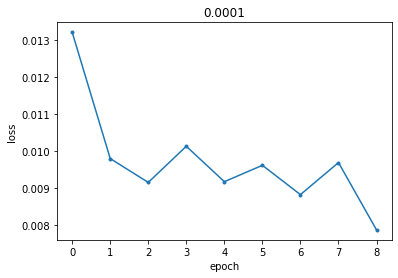

Epoch 1/9
50/50 [==============================] - 54s 1s/step - loss: 0.0086 - vxm_dense_transformer_loss: 0.0084 - vxm_dense_flow_loss: 0.1056
Epoch 2/9
50/50 [==============================] - 54s 1s/step - loss: 0.0091 - vxm_dense_transformer_loss: 0.0089 - vxm_dense_flow_loss: 0.0898
Epoch 3/9
50/50 [==============================] - 55s 1s/step - loss: 0.0086 - vxm_dense_transformer_loss: 0.0084 - vxm_dense_flow_loss: 0.0865
Epoch 4/9
50/50 [==============================] - 55s 1s/step - loss: 0.0087 - vxm_dense_transformer_loss: 0.0085 - vxm_dense_flow_loss: 0.0954
Epoch 5/9
50/50 [==============================] - 55s 1s/step - loss: 0.0082 - vxm_dense_transformer_loss: 0.0080 - vxm_dense_flow_loss: 0.0886
Epoch 6/9
50/50 [==============================] - 53s 1s/step - loss: 0.0083 - vxm_dense_transformer_loss: 0.0081 - vxm_dense_flow_loss: 0.0863
Epoch 7/9
50/50 [==============================] - 53s 1s/step - loss: 0.0078 - vxm_dense_transformer_loss: 0.0076 - vxm_dense_flo

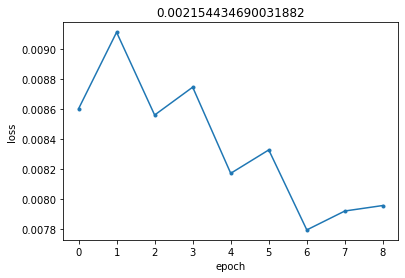

Epoch 1/9
50/50 [==============================] - 56s 1s/step - loss: 0.0090 - vxm_dense_transformer_loss: 0.0080 - vxm_dense_flow_loss: 0.0224
Epoch 2/9
50/50 [==============================] - 55s 1s/step - loss: 0.0098 - vxm_dense_transformer_loss: 0.0090 - vxm_dense_flow_loss: 0.0171
Epoch 3/9
50/50 [==============================] - 59s 1s/step - loss: 0.0096 - vxm_dense_transformer_loss: 0.0089 - vxm_dense_flow_loss: 0.0160
Epoch 4/9
50/50 [==============================] - 54s 1s/step - loss: 0.0090 - vxm_dense_transformer_loss: 0.0082 - vxm_dense_flow_loss: 0.0169
Epoch 5/9
50/50 [==============================] - 51s 1s/step - loss: 0.0094 - vxm_dense_transformer_loss: 0.0086 - vxm_dense_flow_loss: 0.0174
Epoch 6/9
50/50 [==============================] - 51s 1s/step - loss: 0.0099 - vxm_dense_transformer_loss: 0.0091 - vxm_dense_flow_loss: 0.0177
Epoch 7/9
50/50 [==============================] - 51s 1s/step - loss: 0.0085 - vxm_dense_transformer_loss: 0.0078 - vxm_dense_flo

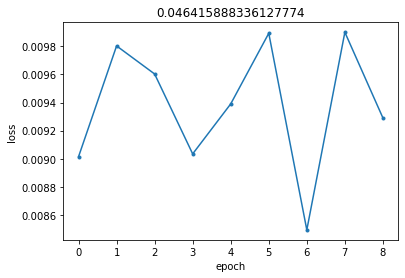

Epoch 1/9
50/50 [==============================] - 51s 1s/step - loss: 0.0139 - vxm_dense_transformer_loss: 0.0120 - vxm_dense_flow_loss: 0.0019
Epoch 2/9
50/50 [==============================] - 51s 1s/step - loss: 0.0126 - vxm_dense_transformer_loss: 0.0114 - vxm_dense_flow_loss: 0.0012
Epoch 3/9
50/50 [==============================] - 51s 1s/step - loss: 0.0130 - vxm_dense_transformer_loss: 0.0118 - vxm_dense_flow_loss: 0.0012
Epoch 4/9
50/50 [==============================] - 51s 1s/step - loss: 0.0119 - vxm_dense_transformer_loss: 0.0107 - vxm_dense_flow_loss: 0.0011
Epoch 5/9
50/50 [==============================] - 51s 1s/step - loss: 0.0121 - vxm_dense_transformer_loss: 0.0111 - vxm_dense_flow_loss: 0.0010
Epoch 6/9
50/50 [==============================] - 52s 1s/step - loss: 0.0131 - vxm_dense_transformer_loss: 0.0120 - vxm_dense_flow_loss: 0.0012
Epoch 7/9
50/50 [==============================] - 52s 1s/step - loss: 0.0120 - vxm_dense_transformer_loss: 0.0110 - vxm_dense_flo

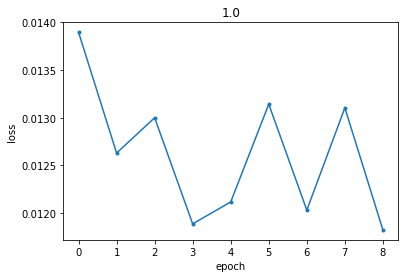

In [52]:
# UNET architecture

vol_shape = (x, y) # 32 slices
nb_features = [
    [16, 32, 32, 32],             # encoder
    [32, 32, 32, 32, 32, 16, 16]  # decoder
]

# build vxm network using VxmDense
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0);

# Losses : MSE + smoothness (regularization) 
losses = ['mse', vxm.losses.Grad('l2').loss]

# Regularizer
lambdas = np.logspace(-4,0,4)
for lambda_ in lambdas :

    loss_weights = [1, lambda_]
    
#     vxm_model = tf.keras.utils.multi_gpu_model(vxm_model, gpus=2)
    # Adam optimizer learning rate
    vxm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=losses, loss_weights=loss_weights)
    
    # Training
    train_generator = vxm_data_generator(slices_train, batch_size = 1)
    hist = vxm_model.fit(train_generator, epochs=9, steps_per_epoch= 50, verbose=1);
    # Visualize the losses
    plot_history(hist, save_name = str(lambda_))
    title = "weights" + str(lambda_) + ".keras"
    # If it looks ok => save the weights
    vxm_model.save_weights(title)

In [53]:
title = "weights" + str(0.002154434690031882) + ".keras"
vxm_model.load_weights(title)
# Validation set generator
val_generator = vxm_data_generator(slices_test, batch_size = 15)
val_input, _ = next(val_generator)
our_val_pred = vxm_model.predict(val_input);

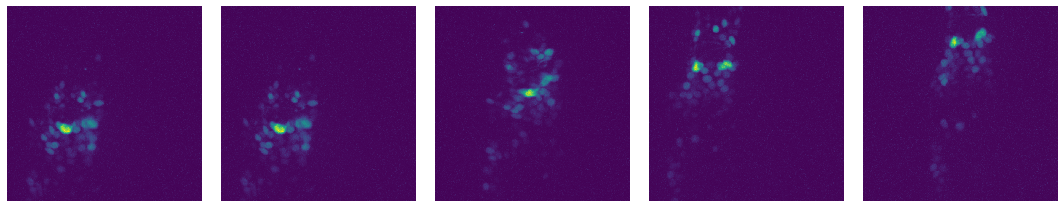

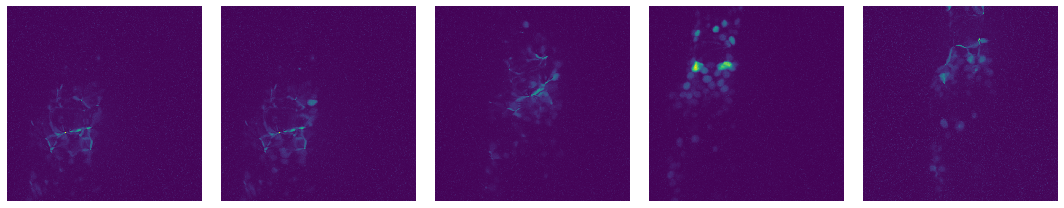

In [54]:
moving = np.squeeze(val_input[0])
fixed = np.squeeze(val_input[1])
moved = np.squeeze(our_val_pred[0])

a = [moved[i, ...] for i in range(5)]
b = [moving[i, ...] for i in range(5)]


# Moving
ne.plot.slices(b, do_colorbars=True);
# Moved
ne.plot.slices(a, do_colorbars=True);